# Movie Recommendation Engine

The purpose of this notebook is to implement a recommendation engine end-to-end.

I have briefly touched on the math and the logic behind this factinating domain of Machine Learning in the previous post [Bridging Recommender Systems and Dimensionality Reduction](http://francescopochetti.com/bridging-recommender-systems-dimensionality-reduction/), therefore I am going to save time and typing here. 

As a brief refresh, there are three main ways to approch a recommender system challenge: **content based**, **collaborative filtering** and **low rank factorization** or **latent factor models**. The third is the one we are about to discover. The exercise consists in predicting missing movie ratings (on a scale of 1 to 5) in a $m \times u$ (1682 $\times$ 943) matrix of *m* movies and *u* users ([dataset](https://grouplens.org/datasets/movielens/)).

### The matrices


Here some additional details about the matrices we are going to encounter below.
The matrix *Y* (a $m \times u$ matrix) stores the ratings $y^{(i,j)}$ (from 1 to 5). The matrix *R* is an binary-valued indicator matrix, where $R_{(i, j)} = 1$ if user *j* gave a rating to movie *i*, and $R_{(i, j)} = 0$ otherwise. The
objective of the model is to predict movie ratings for the movies that users have not yet rated, that is, the entries with $R_{(i, j)} = 0$. This will allow us to recommend the movies with the highest predicted ratings to the user.
Throughout the exercise, we will also be working with the matrices, *X* and $\Theta$. The *i*-th row of *X* corresponds to the feature vector $x^{(i)}$ for the *i*-th movie, and the *j*-th row of $\Theta$ corresponds to one parameter vector $\theta^{(j)}$, for the *j*-th user. Both $x^{(i)}$ and $\theta^{(j)}$ are *n*-dimensional vectors. For the purposes of
this exercise, we will use n = 100, and therefore, $x^{(i)} \in \mathcal{R}^{n}$ and $\theta^{(j)} \in \mathcal{R}^{n}$.
Correspondingly, *X* is a $m \times n$ matrix and $\Theta$ is a $u \times n$ matrix.


### The learning algorithm 

The low rank factorization algorithm in the setting of movie recommendations considers a set of *n*-dimensional parameter vectors $x^{(1)}, \cdots , x^{(m)}$ and $\theta^{(1)}, \cdots , \theta^{(u)}$, where the model predicts the rating for movie *i* by user *j* as $y^{(i,j)} = (\theta^{(j)})^T x^{(i)}$. Given a dataset that consists of a set of ratings produced by some users on some movies, we wish to learn the parameter vectors $x^{(1)}, \cdots , x^{(m)}, \theta^{(1)}, \cdots , \theta^{(u)}$ that produce the best fit (minimizes the squared error).

### The regularized cost function... 

The cost function we want to minimize is

$J(x^{(1)}, \cdots , x^{(m)}, \theta^{(1)}, \cdots , \theta^{(u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1}\Big((\theta^{(j)})^T x^{(i)} - y^{(i,j)}\Big)^2 + \Big( \frac{\lambda}{2} \sum_{j=1}^u \sum_{k=1}^n (\theta_k^{(j)})^2 \Big) + \Big( \frac{\lambda}{2} \sum_{i=1}^m \sum_{k=1}^n (x_k^{(i)})^2 \Big)$

### ...and its gradient 

whose gradient w.r.t. $\Theta$ and $X$ is respectively equal to

$\frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1}\Big((\theta^{(j)})^T x^{(i)} - y^{(i,j)}\Big)\theta_k^{(j)} + \lambda x_k^{(i)}$

$\frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1}\Big((\theta^{(j)})^T x^{(i)} - y^{(i,j)}\Big)x_k^{(i)} + \lambda \theta_k^{(j)}$

I think we are all set. Now we can start playing around with real code.

In [184]:
import scipy.io
import random
import numpy as np
import pandas as pd
import time
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

## Functions

In [185]:
def cofiCostFunction(weights, Y, R, num_users, num_movies, num_features, lamb):
    """
        X - num_movies  x num_features matrix of movie features
        Theta - num_users  x num_features matrix of user features
        Y - num_movies x num_users matrix of user ratings of movies
        R - num_movies x num_users matrix, where R(i, j) = 1 if the 
            i-th movie was rated by the j-th user


        X_grad - num_movies x num_features matrix, containing the 
                 partial derivatives w.r.t. to each element of X
        Theta_grad - num_users x num_features matrix, containing the 
                     partial derivatives w.r.t. to each element of Theta

    """
    
    X = weights[0:num_movies * (num_features)].reshape(num_movies, num_features) #contains n features per movie
    Theta = weights[num_movies * (num_features):].reshape(num_users, num_features) #contains n features per user 
    
    cost = 0.5 * (((R * X.dot(Theta.T)) - Y)**2).sum() + lamb/2 * (Theta**2).sum() + lamb/2 * (X**2).sum()
    
    X_grad = np.zeros((num_movies, num_features))
    Theta_grad = np.zeros((num_users, num_features)) 
    
    for m in range(num_movies):
        #get all users who have rated movie m; this is a boolean array with size (1, users_watched_movie_m)
        users_watched_movie_m = R[m,:] == 1
        
        #from Theta containing n features per user, get all the features for all users_watched_movie_m
        #size (users_watched_movie_m, n_features)
        Theta_m = Theta[users_watched_movie_m,:]
        #from Y containing (movies, users), get all the ratings for all users_watched_movie_m
        #size (1, users_watched_movie_m)        
        Y_m = Y[m, users_watched_movie_m].reshape((1, users_watched_movie_m.sum()))
        
        #X[m,:] --> (1, n_features)
        #X[m,:].dot(Theta_m.T) --> (1, users_watched_movie_m)
        #X[m,:].dot(Theta_m.T) - Y_m --> (1, users_watched_movie_m)
        #(X[m,:].dot(Theta_m.T) - Y_m).dot(Theta_m) --> (1, n_features)
        X_grad[m, :] = (X[m,:].dot(Theta_m.T) - Y_m).dot(Theta_m) + lamb * X[m,:]

    for u in range(num_users):
        #get all movies rated by user u
        movies_rated_by_user_u = R[:,u] == 1

        #from X containing n features per movie, get all the features for all movies_rated_by_user_u
        #size (movies_rated_by_user_u, n_features)
        X_u = X[movies_rated_by_user_u,:]
        #from Y containing (movies, users), get all the ratings for all movies_rated_by_user_u
        #size (movies_rated_by_user_u, 1)        
        Y_u = Y[movies_rated_by_user_u, u].reshape((movies_rated_by_user_u.sum(), 1))
        Theta_u = Theta[u, :].reshape((1, num_features))
        
        #X_u --> (movies_rated_by_user_u, n_features)
        #X_u.dot(Theta_u.T) --> (movies_rated_by_user_u, 1)
        #X_u.dot(Theta_u.T) - Y_u --> (movies_rated_by_user_u, 1)
        #(X_u.dot(Theta_u.T) - Y_u).T.dot(X_u) --> (1, n_features)
        Theta_grad[u, :] = (X_u.dot(Theta_u.T) - Y_u).T.dot(X_u) + lamb * Theta_u  
    
    return np.asscalar(cost.squeeze()), np.vstack((X_grad.reshape(X_grad.size, 1), Theta_grad.reshape(Theta_grad.size, 1))).flatten()

def loadMovieList():
    d = {}
    with open('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex8-005\\mlclass-ex8\movie_ids.txt') as f:
        for line in f:
           (key, val) = line.split(' ', 1)
           d[int(key)] = val.rstrip()
    return d

def normalizeRatings(Y, R):
    """returns normalized Y (and its mean) so that each movie
       has a rating of 0 on average"""
    movie_av = np.zeros((Y.shape[0], 1))
    
    for m in range(Y.shape[0]):
        to_be_averaged = R[m,:] == 1
        movie_av[m] = Y[m, to_be_averaged].mean()
    
    return Y - movie_av, movie_av

### Running the model on pre-trained weights

This is just to check that the cost function works as expected. The printed value is a benchmark calculated on smaller matrices and offered during Andrew Ng's course, and my result perfectly matches his. So, good news, we can go ahead. 

In [186]:
data = scipy.io.loadmat('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex8-005\\mlclass-ex8\ex8_movies.mat')
R = data['R']
Y = data['Y']

params = scipy.io.loadmat('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex8-005\\mlclass-ex8\ex8_movieParams.mat')
Theta = params['Theta']
X = params['X']

#  Reduce the data set size just for checking purposes
num_users = 4
num_movies = 5
num_features = 3
X = X[0:num_movies, 0:num_features]
Theta = Theta[0:num_users, 0:num_features]
Y = Y[0:num_movies, 0:num_users]
R = R[0:num_movies, 0:num_users]

weights = np.vstack((X.reshape(X.size, 1), Theta.reshape(Theta.size, 1)))

#  Evaluate cost function
cost, gradient = cofiCostFunction(weights, Y, R, num_users, num_movies, num_features, 1.5)
print('Regularized Cost @lambda 10:', cost)

Regularized Cost @lambda 10: 31.34405624427422


## Implementing the Low Rank Factorization Algorithm

Loading the whole dataset (*Y* and *R*) and "visualizing" the $movies \times users$ (1682 $\times$ 943) *Y* matrix. *imshow* nicely allows us to highlight the 1 to 5 ratings and the missing entries. As you can see the matrix is (as expected) pretty sparse.

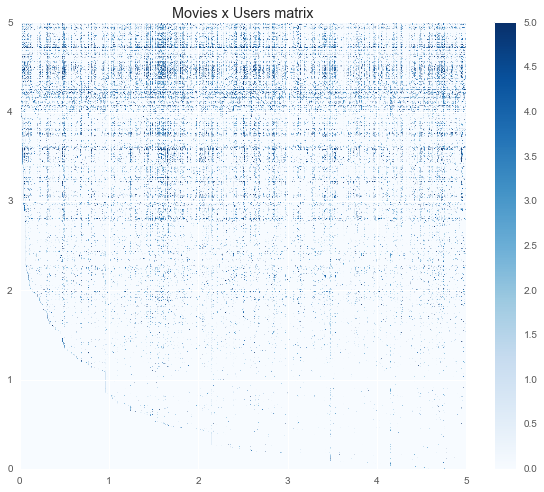

In [187]:
data = scipy.io.loadmat('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex8-005\\mlclass-ex8\ex8_movies.mat')
R = data['R']
Y = data['Y']

plt.figure(figsize=(10, 8))
plt.imshow(Y, extent=[0, 5, 0, 5], cmap='Blues')
plt.colorbar()
plt.title('Movies x Users matrix')
plt.show()

In [188]:
# loading the movie list with ratings.
# this is in order to input my personal reviews
movieList = loadMovieList()

my_ratings = np.zeros((Y.shape[0], 1))
my_ratings[0] = 3
my_ratings[1] = 4
my_ratings[7] = 1
my_ratings[10]= 5
my_ratings[21]= 5
my_ratings[26]= 4
my_ratings[27]= 5
my_ratings[34]= 1
my_ratings[55]= 5
my_ratings[1234]= 3
my_ratings[1167]= 2
my_ratings[1088]= 3
my_ratings[1001]= 2
my_ratings[819]= 1
my_ratings[688]= 5
my_ratings[627]= 4
my_ratings[526]= 3
my_ratings[456]= 1

print("Let's rate some movies I have watched...\nThis is important to get future recommendations!\n")

for movie in range(my_ratings.shape[0]):
    if my_ratings[movie] > 0:
        print('Movie: "%s". My rating: %d' % (movieList[movie+1], my_ratings[movie])) 

Let's rate some movies I have watched...
This is important to get future recommendations!

Movie: "Toy Story (1995)". My rating: 3
Movie: "GoldenEye (1995)". My rating: 4
Movie: "Babe (1995)". My rating: 1
Movie: "Seven (Se7en) (1995)". My rating: 5
Movie: "Braveheart (1995)". My rating: 5
Movie: "Bad Boys (1995)". My rating: 4
Movie: "Apollo 13 (1995)". My rating: 5
Movie: "Free Willy 2: The Adventure Home (1995)". My rating: 1
Movie: "Pulp Fiction (1994)". My rating: 5
Movie: "Free Willy 3: The Rescue (1997)". My rating: 1
Movie: "Gandhi (1982)". My rating: 3
Movie: "Sleepers (1996)". My rating: 4
Movie: "Jackal, The (1997)". My rating: 5
Movie: "Space Jam (1996)". My rating: 1
Movie: "Pest, The (1997)". My rating: 2
Movie: "Speed 2: Cruise Control (1997)". My rating: 3
Movie: "Little Buddha (1993)". My rating: 2
Movie: "Big Bang Theory, The (1994)". My rating: 3


In [189]:
#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies on 
#  943 users
#
#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
#  rating to movie i
data = scipy.io.loadmat('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex8-005\\mlclass-ex8\ex8_movies.mat')
R = data['R']
Y = data['Y']

#  Add our own ratings to the data matrix
Y = np.hstack((Y, my_ratings))
R = np.hstack((R, np.where(my_ratings != 0, 1, 0)))

#  Normalize Ratings
Ynorm, Ymean = normalizeRatings(Y, R)

#  Useful Values
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 100

####################################################
# Guessing Initial Parameters (Theta, X)
####################################################
# This is done by performing an SVD on Y,
# then reconstructing Theta by multiplying s and V
# and then truncating X and Theta's columns to account for the right number of features.
# It is generally a good idea to initialize the parameters with SVD
# as this decomposition guarantees by definition the lowest possible 
# reconstruction erro of Y, so it helps us going in the right direction.
# At the end of the day we have to produce X and Theta so that the RMSE
# between Y and Theta x X over the non null values of Y is as small as possible.
# The problem with SVD is that it assumes all the missing values are 0, hence the 
# decomposition will yield ineherently wrong results. This is why we need
# an additional optimization on top of it.
X, s, V = np.linalg.svd(Ynorm, full_matrices=False)

features = s.shape[0]
S = np.zeros((features, features))
S[:features, :features] = np.diag(s)

Theta = np.dot(S, V)[:,:num_features]
X = X[:,:num_features]

initial_weights = np.vstack((X.reshape(X.size, 1), Theta.reshape(Theta.size, 1)))

print('Y dimensions:', Y.shape)
print('R dimensions:', R.shape)
print('X dimensions:', X.shape)
print('Theta dimensions:', Theta.shape)

Y dimensions: (1682, 944)
R dimensions: (1682, 944)
X dimensions: (1682, 100)
Theta dimensions: (944, 100)


In [190]:
# Set Regularization
lamb = 10
start = time.time()

opt_results = scipy.optimize.minimize(fun=cofiCostFunction, x0=initial_weights.squeeze(), 
                                       args=(Ynorm, R, num_users, num_movies, num_features, lamb), 
                                       jac=True, method='TNC', options={'disp':True})
end = time.time()
opt_results

     fun: 7392279.00696755
     jac: array([ -1.74412433e-06,  -8.55478169e-07,  -2.55634779e-06, ...,
         9.30204157e-08,  -1.35419401e-08,   4.25925383e-07])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 1164
     nit: 55
  status: 1
 success: True
       x: array([-0.3450651 , -0.33919942, -0.22434563, ...,  0.05467321,
        0.08744782, -0.10401336])

In [191]:
total = end-start
print("Training executed in", round(total/60, 2), "minutes")

Training executed in 4.86 minutes


## Recommended for me! 

After training the model, we can now make recommendations by computing the predictions matrix and then display the top movies I really cannot miss!

In [192]:
# Unfold the returned weights into X and Theta
X = opt_results.x[0:num_movies * (num_features)].reshape(num_movies, num_features) 
Theta = opt_results.x[num_movies * (num_features):].reshape(num_users, num_features) 

predicted = X.dot(Theta.T)
mine = predicted[:,num_users - 1] + Ymean.flatten()
top = np.argsort(mine)[::-1][:20]

### Top 20 movies I never watched and I cannot miss!

In [193]:
print('Top Recommended Movies\n')
for rank, index in enumerate(top):
    if index not in [movie for (movie, rating) in enumerate(my_ratings) if rating > 0]:
        print('%d: "%s". Predicted rating: %2.2f' % (rank+1, movieList[index+1], mine[index])) 

Top Recommended Movies

1: "Star Kid (1997)". Predicted rating: 5.00
2: "Aiqing wansui (1994)". Predicted rating: 5.00
3: "Someone Else's America (1995)". Predicted rating: 5.00
4: "They Made Me a Criminal (1939)". Predicted rating: 5.00
5: "Santa with Muscles (1996)". Predicted rating: 5.00
6: "Prefontaine (1997)". Predicted rating: 5.00
7: "Entertaining Angels: The Dorothy Day Story (1996)". Predicted rating: 5.00
8: "Marlene Dietrich: Shadow and Light (1996)". Predicted rating: 5.00
9: "Saint of Fort Washington, The (1993)". Predicted rating: 5.00
10: "Great Day in Harlem, A (1994)". Predicted rating: 5.00
11: "Pather Panchali (1955)". Predicted rating: 4.64
12: "Shawshank Redemption, The (1994)". Predicted rating: 4.60
13: "Titanic (1997)". Predicted rating: 4.54
14: "Maya Lin: A Strong Clear Vision (1994)". Predicted rating: 4.52
15: "Usual Suspects, The (1995)". Predicted rating: 4.50
16: "Everest (1998)". Predicted rating: 4.50
18: "Anna (1996)". Predicted rating: 4.49
19: "Some